In [35]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
plt.style.use('ggplot')
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose 
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import make_scorer 
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import os



In [39]:
df=pd.read_csv('all_stocks_5yr.csv')
# df.dropna(inplace=True)
perc =[.20, .40, .60, .80] 
include =['object', 'float', 'int'] 
desc = df.describe(percentiles = perc, include = include) 
desc

,date,open,high,low,close,Name
count,619040,619029.000000,619032.000000,619032.000000,619040.000000,619040
unique,1259,NaN,NaN,NaN,NaN,505
top,12/8/2017,NaN,NaN,NaN,NaN,EL
freq,505,NaN,NaN,NaN,NaN,1259
mean,NaN,83.023334,83.778311,82.256096,83.043763,NaN
std,NaN,97.378769,98.207519,96.507421,97.389748,NaN
min,NaN,1.620000,1.690000,1.500000,1.590000,NaN
20%,NaN,35.888000,36.240000,35.520000,35.890000,NaN
40%,NaN,52.810000,53.301660,52.330000,52.830000,NaN
50%,NaN,62.590000,63.150000,62.020000,62.620000,NaN


In [17]:
df.isnull().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

In [5]:
df['open'] = df['open'].fillna((df['open'].mean()))
df['high'] = df['high'].fillna((df['high'].mean()))
df['low'] = df['low'].fillna((df['low'].mean()))


In [6]:
df['date']=pd.to_datetime(df['date'])
start=('01-01-2017')
end=('01-01-2018')
ma = (df['date'] >= start) & (df['date'] <= end)
df=df.loc[ma]

In [7]:
df.set_index('date',inplace=True)
HP_df=df[df['Name'] =='HP']
UAA_df=df[df['Name']=='UAA']



In [217]:
HP_df.head()


,open,high,low,close,volume,Name
date,,,,,,
2017-01-03,78.52,79.67,77.65,78.76,1452299,HP
2017-01-04,79.12,79.76,78.45,78.54,1286599,HP
2017-01-05,78.91,79.31,77.81,78.80,1235776,HP
2017-01-06,79.14,81.30,78.15,81.07,1638854,HP
2017-01-09,81.04,81.10,78.75,79.30,1927285,HP


In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 126032 entries, 2017-01-03 to 2017-12-29
Data columns (total 6 columns):
open      126032 non-null float64
high      126032 non-null float64
low       126032 non-null float64
close     126032 non-null float64
volume    126032 non-null int64
Name      126032 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 6.7+ MB


In [203]:
close_UAA = UAA_df['close']
close_HP=HP_df['close']
close_UAA[1]


30.54

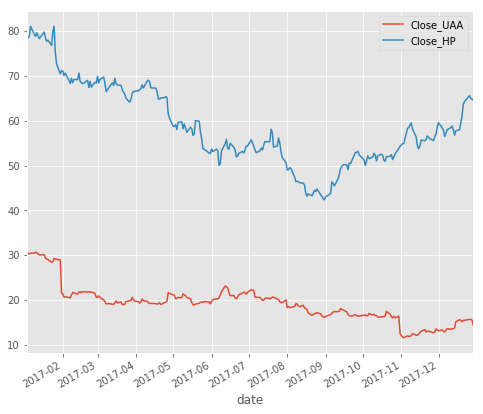

In [248]:
close_UAA.plot(label='Close_UAA')
close_HP.plot(label='Close_HP')
plt.legend()
plt.show()

In [240]:
low=UAA_df['low'].asfreq('D')

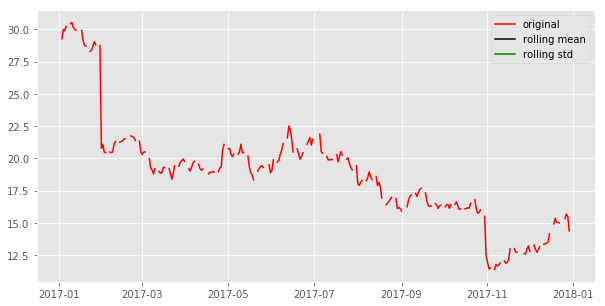

In [241]:
def plot_rolling(UAA_df,window=100):
    rolling_mean=UAA_df.rolling(window).mean()
    rolling_std=UAA_df.rolling(window).std()
    plt.figure(figsize=(10,5))
    plt.plot(UAA_df,label='original',color='red')
    plt.plot(rolling_mean,label='rolling mean',color='black')
    plt.plot(rolling_std,label='rolling std',color='green')
    plt.legend(loc='best')
    plt.show()
    
plot_rolling(low)

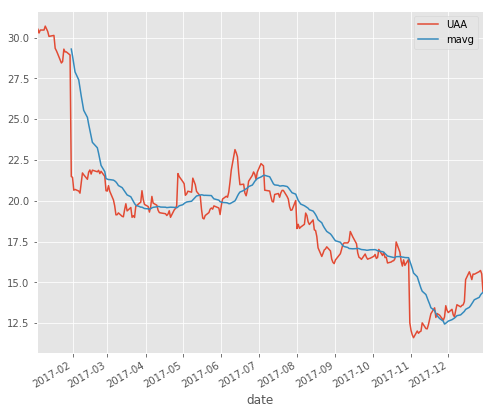

In [251]:
mavg = close_UAA.rolling(window=20).mean()
# Adjusting the size of matplotlib
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_UAA.plot(label='UAA')
mavg.plot(label='mavg')
plt.legend()

                                   Linear Regression by statsmodels

In [29]:
df[0:2]

,date,open,high,low,close,volume,Name
0,2/8/2013,15.07,15.12,14.63,14.75,8407500,AAL
1,2/11/2013,14.89,15.01,14.26,14.46,8882000,AAL


In [30]:
df['pct_change']=df.groupby(['Name']).close.pct_change()

In [31]:
df[0:3]

,date,open,high,low,close,volume,Name,pct_change
0,2/8/2013,15.07,15.12,14.63,14.75,8407500,AAL,NaN
1,2/11/2013,14.89,15.01,14.26,14.46,8882000,AAL,-0.019661
2,2/12/2013,14.45,14.51,14.10,14.27,8126000,AAL,-0.013140


In [32]:
slim_stock=df[['date','Name','pct_change']]
slim_stock[0:3]

,date,Name,pct_change
0,2/8/2013,AAL,NaN
1,2/11/2013,AAL,-0.019661
2,2/12/2013,AAL,-0.013140


In [33]:
reshaped=slim_stock.pivot(index='date',columns='Name',values='pct_change')
reshaped[0:2]

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
1/10/2014,0.008903,-0.002379,0.018406,-0.006671,-0.006248,-0.000560,0.007639,0.003014,0.007446,0.000202,...,0.000658,-0.000437,0.007618,0.000818,-0.004979,0.008085,-0.000400,0.002177,-0.005295,0.018148
1/10/2017,-0.000831,0.029737,0.002300,0.001008,-0.002180,-0.007604,0.013500,0.000522,-0.002855,0.005699,...,0.004897,-0.008974,-0.012753,-0.005131,0.008608,-0.004659,0.005882,0.062336,0.015385,-0.000371


In [34]:
x=reshaped[['AAPL','AMZN','KO','UAL','GE']]
y=reshaped['GOOG']
x=sm.add_constant(x)
model=sm.OLS(y,x,missing='drop').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GOOG   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     147.5
Date:                Wed, 26 Jun 2019   Prob (F-statistic):          2.12e-116
Time:                        14:43:29   Log-Likelihood:                 3047.2
No. Observations:                 974   AIC:                            -6082.
Df Residuals:                     968   BIC:                            -6053.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.515e-06      0.000      0.013      0.989      -0.001       0.001
AAPL           0.1653      0.027      6.187      0.000       0.113       0.218
AMZN           0.3533      0.020     17.569      0.000       0.314       0.393
KO             0.1596      0.042      3.791      0.000       0.077       0.242
UAL            0.0686      0.015      4.516      0.000       0.039       0.098
GE             0.1200      0.030      3.987      0.000       0.061       0.179
==============================================================================
Omnibus:                      770.701   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91312.081
Skew:                           2.857   Prob(JB):                         0.00
Kurtosis:                      50.089   Cond. No.                         126.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
df2=pd.read_csv('^GSPC (1).csv')
df2.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2/7/2013,1512.119995,1512.900024,1498.489990,1509.390015,1509.390015,3614580000
1,2/8/2013,1509.390015,1518.310059,1509.390015,1517.930054,1517.930054,2986150000
2,2/11/2013,1517.930054,1518.310059,1513.609985,1517.010010,1517.010010,2684100000
3,2/12/2013,1517.010010,1522.290039,1515.609985,1519.430054,1519.430054,3414370000
4,2/13/2013,1519.430054,1524.689941,1515.930054,1520.329956,1520.329956,3385880000


In [66]:
df2['Name']='SP'

In [70]:
df2['date']=df2[['Date']]
df2.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name,date,pct_change
0,2/7/2013,1512.119995,1512.900024,1498.489990,1509.390015,1509.390015,3614580000,SP,2/7/2013,NaN
1,2/8/2013,1509.390015,1518.310059,1509.390015,1517.930054,1517.930054,2986150000,SP,2/8/2013,0.005658
2,2/11/2013,1517.930054,1518.310059,1513.609985,1517.010010,1517.010010,2684100000,SP,2/11/2013,-0.000606
3,2/12/2013,1517.010010,1522.290039,1515.609985,1519.430054,1519.430054,3414370000,SP,2/12/2013,0.001595
4,2/13/2013,1519.430054,1524.689941,1515.930054,1520.329956,1520.329956,3385880000,SP,2/13/2013,0.000592


In [69]:
df2['pct_change']=df2.groupby(['Name']).Close.pct_change()

In [73]:
sl_stock=df2[['date','Name','pct_change']]
sl_stock[0:2]

,date,Name,pct_change
0,2/7/2013,SP,NaN
1,2/8/2013,SP,0.005658


In [74]:
reshap=sl_stock.pivot(index='date',columns='Name',values='pct_change')
reshap[0:2]

Name,SP
date,
1/10/2014,0.002307
1/10/2017,0.000000


In [75]:
df3=pd.merge(reshaped,reshap,on='date',how='inner')
df3.head()

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS,SP
date,,,,,,,,,,,,,,,,,,,,,
1/10/2014,0.008903,-0.002379,0.018406,-0.006671,-0.006248,-0.000560,0.007639,0.003014,0.007446,0.000202,...,-0.000437,0.007618,0.000818,-0.004979,0.008085,-0.000400,0.002177,-0.005295,0.018148,0.002307
1/10/2017,-0.000831,0.029737,0.002300,0.001008,-0.002180,-0.007604,0.013500,0.000522,-0.002855,0.005699,...,-0.008974,-0.012753,-0.005131,0.008608,-0.004659,0.005882,0.062336,0.015385,-0.000371,0.000000
1/10/2018,-0.013655,0.032642,0.000905,-0.000229,-0.005487,-0.003179,-0.001527,-0.003512,0.002196,-0.016696,...,-0.009888,-0.007952,-0.041100,0.005300,-0.007194,-0.002537,-0.013367,0.010423,-0.015977,-0.001112
1/11/2016,-0.016844,0.017587,0.010236,0.016192,-0.031806,-0.039812,0.001475,0.010489,0.017416,0.023810,...,0.004426,-0.013389,-0.019477,-0.019812,-0.008438,-0.001761,-0.017233,-0.019919,-0.028335,0.000853
1/11/2017,0.023909,0.003300,0.020657,0.005373,-0.045731,-0.038901,-0.005086,0.009213,0.006743,0.003732,...,-0.000513,0.010241,-0.008939,-0.004267,0.005291,-0.007541,0.009501,0.008264,-0.011496,0.002830


In [77]:
x=df3[['AAPL','AMZN','KO','UAL','GE','SP']]
y=df3['GOOG']
x=sm.add_constant(x)
model=sm.OLS(y,x,missing='drop').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GOOG   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     151.8
Date:                Sun, 30 Jun 2019   Prob (F-statistic):          1.40e-135
Time:                        15:02:30   Log-Likelihood:                 3093.5
No. Observations:                 973   AIC:                            -6173.
Df Residuals:                     966   BIC:                            -6139.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.106e-05      0.000     -0.248      0.804      -0.001       0.001
AAPL           0.0356      0.028      1.251      0.211      -0.020       0.091
AMZN           0.2846      0.020     14.029      0.000       0.245       0.324
KO            -0.0118      0.044     -0.272      0.786      -0.097       0.074
UAL            0.0220      0.015      1.446      0.148      -0.008       0.052
GE            -0.0485      0.033     -1.458      0.145      -0.114       0.017
SP             0.7631      0.076     10.006      0.000       0.613       0.913
==============================================================================
Omnibus:                      896.023   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           148433.880
Skew:                           3.594   Prob(JB):                         0.00
Kurtosis:                      63.080   Cond. No.                         253.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""